In [1]:
import requests, zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from io import BytesIO
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

Getting the data

In [2]:
# r = requests.get('https://archive.ics.uci.edu/static/public/222/bank+marketing.zip')
# z = zipfile.ZipFile(BytesIO(r.content))

# Data from the URL is temporary unavaliable
# Using local zip-archive 

z = zipfile.ZipFile('Data/bank+marketing.zip')
zz = zipfile.ZipFile(BytesIO(z.read('bank.zip')))
df = pd.read_csv(BytesIO(zz.read('bank-full.csv')), sep=';')
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


Removing the 'default' column

In [3]:
df.drop('default', axis=1, inplace=True)
df.head(3)

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


### Splitting the data

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. 

Use train_test_split function for that with random_state=1

In [4]:
df['y'] = [1 if c == 'yes' else 0 for c in df['y'] ]

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

X_train = df_train.loc[:, df.columns != 'y'].copy()
X_val = df_val.loc[:, df.columns != 'y'].copy()
X_test = df_test.loc[:, df.columns != 'y'].copy()

y_train = df_train['y'].values
y_val = df_val['y'].values
y_test = df_test['y'].values

for d in [X_train, X_val, X_test]:
    print(round(len(d)/len(df),2))

0.6
0.2
0.2


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

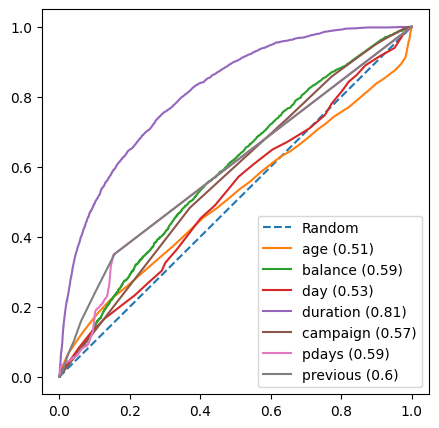

In [5]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='Random', linestyle='--')

num_cols = X_train.columns[X_train.dtypes == np.int64]

for col in num_cols:
    fpr, tpr, thresholds = roc_curve(y_train, X_train[col])
    auc_value = auc(fpr, tpr)

    if auc_value < 0.5:
        fpr, tpr, thresholds = roc_curve(y_train, -X_train[col])
        auc_value = auc(fpr, tpr)
    label = f'{col} ({round(auc_value,2)})'
    plt.plot(fpr, tpr, label=label)

plt.legend()
plt.show()

### Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

AUC: 0.902


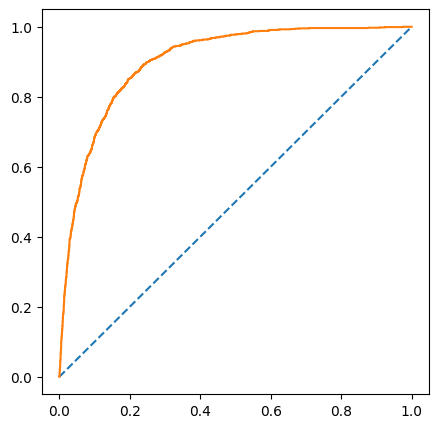

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = X_train.to_dict(orient='records')
X_train_1hot = dv.fit_transform(train_dict)

val_dict = X_val.to_dict(orient='records')
X_val_1hot = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_1hot, y_train)

y_pred = model.predict_proba(X_val_1hot)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc_value = auc(fpr, tpr)

print(f'AUC: {round(auc_value, 3)}')
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='Random', linestyle='--')
plt.plot(fpr, tpr)
plt.show()

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

In [7]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

thresholds = np.linspace(0., 1., 101)
precisions = []
recalls = []

for thr in thresholds:
    predict_positive = (y_pred >= thr)
    predict_negative = (y_pred < thr)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
     
    precisions.append(tp / (tp + fp))
    recalls.append(tp / (tp + fn))

# Warning because of nan (due to 0/0 in precision at treshold=1)

/tmp/ipykernel_132577/433165953.py:18: RuntimeWarning: invalid value encountered in scalar divide
  precisions.append(tp / (tp + fp))


Intersection at threshold 0.26


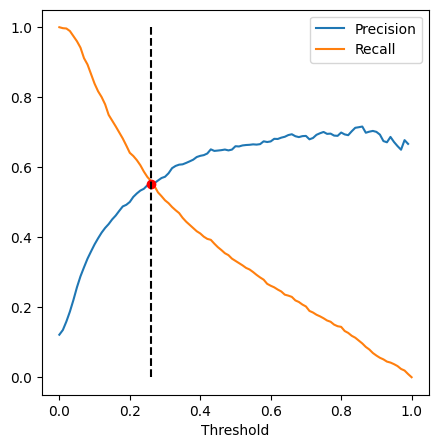

In [8]:
plt.figure(figsize=(5,5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')

idx = np.argwhere(np.diff(np.sign(np.array(recalls) - np.array(precisions)))).flatten()[0] # ignoring last nan 
plt.plot(thresholds[idx], np.array(precisions)[idx], 'ro') 
plt.plot([thresholds[idx], thresholds[idx]], [0, 1], color='black', linestyle='--')

plt.xlabel('Threshold')
plt.legend()

print(f'Intersection at threshold {thresholds[idx]}')

plt.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = (2 * P * R)/(P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

Max F1 is equal to 0.569 at threshold 0.18


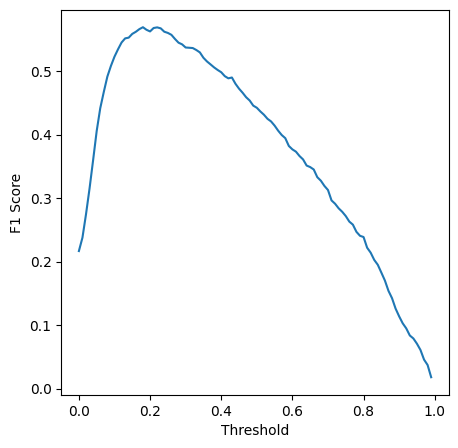

In [9]:
F1 = []

for p, r in zip(precisions, recalls):
    F1.append(2*p*r/(p+r))

plt.figure(figsize=(5,5))
plt.plot(thresholds, F1)

plt.xlabel('Threshold')
plt.ylabel('F1 Score')

max_F1 = max(F1)
max_F1_t = thresholds[F1.index(max_F1)]

print(f'Max F1 is equal to {round(max_F1, 3)} at threshold {round(max_F1_t,3)}')

plt.show()

### Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

In [10]:
categorical = X_train.columns[X_train.dtypes==object].to_list()
numerical = X_train.columns[X_train.dtypes==np.int64].to_list()


def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model


def predict(df_pred, dv, model):
    dicts = df_pred[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [11]:
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['y'].values
    y_val = df_val['y'].values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

round(np.std(scores), 3)

0.006

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.000001, 0.001, 1]
* Initialize KFold with the same parameters as previously
* Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

In [12]:
n_splits = 5

for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['y'].values
        y_val = df_val['y'].values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.701 +- 0.009
C=0.001 0.863 +- 0.007
C=1 0.907 +- 0.006
